### APAN5420 Anomaly Detection - Assignment 9

### Name: Kanyarat Suwannama

* **Section1**: Data Preparation
* **Section2**: Modeling in H2o
* **Section3**: Feature Engineering 
* **Section4**: GBM model
* **Section5**: Deep Learning model
* **Section6**: Conclusion

# Section 1: Data preparation

In [1]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Use Pandas to do data preparation

In [2]:
data = pd.read_csv("XYZloan_default_selected_vars.csv")

### This is description

In [3]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(
     data, test_size=0.40, random_state=42)

In [4]:
train.shape

(48000, 89)

In [5]:
var = pd.DataFrame(train.dtypes)
var.head(10)

,0
Unnamed: 0.1,int64
Unnamed: 0,int64
id,int64
loan_default,int64
AP001,int64
AP002,int64
AP003,int64
AP004,int64
AP005,object
AP006,object


In [6]:
var = pd.DataFrame(train.dtypes).reset_index()
var.head()

,index,0
0,Unnamed: 0.1,int64
1,Unnamed: 0,int64
2,id,int64
3,loan_default,int64
4,AP001,int64


In [7]:
var.columns = ['varname','dtype'] 
var.head(10)

,varname,dtype
0,Unnamed: 0.1,int64
1,Unnamed: 0,int64
2,id,int64
3,loan_default,int64
4,AP001,int64
5,AP002,int64
6,AP003,int64
7,AP004,int64
8,AP005,object
9,AP006,object


In [8]:
var['source'] = var['varname'].str[:2]
var.head()

,varname,dtype,source
0,Unnamed: 0.1,int64,Un
1,Unnamed: 0,int64,Un
2,id,int64,id
3,loan_default,int64,lo
4,AP001,int64,AP


In [9]:
var['source'].value_counts()

CD    36
TD    24
AP     9
CR     8
PA     6
Un     2
MB     2
id     1
lo     1
Name: source, dtype: int64

In [10]:
# "AP004" is a bad data field and should be removed.
MB_list = list(var[var['source']=='MB']['varname'])
AP_list = list(var[(var['source']=='AP') & (var['varname']!='AP004')]['varname'])
TD_list = list(var[var['source']=='TD']['varname'])
CR_list = list(var[var['source']=='CR']['varname'])
PA_list = list(var[var['source']=='PA']['varname'])
CD_list = list(var[var['source']=='CD']['varname'])
AP_list

['AP001', 'AP002', 'AP003', 'AP005', 'AP006', 'AP007', 'AP008', 'AP009']

In [11]:
train['loan_default'].value_counts(dropna=False)

0    38736
1     9264
Name: loan_default, dtype: int64

# Section 2:  Feature Engineering 

### Bin the train and test dataset

In [12]:
features = ['loan_default','AP001', 'AP003', 'AP008', 'CR009', 'CR015', 'CR019', 'PA022', 'PA023', 'PA029', 'TD001', 'TD005', 'TD006', 'TD009', 'TD010', 'TD014']
df = data[features]

In [13]:
# Check for missing values
missing_values = df.isnull().sum()
missing_values_per = (df.isnull().sum() / df.isnull().count())
pd.concat([missing_values, missing_values_per],axis=1, keys = ['Count_of_Missing','Percentage'])

,Count_of_Missing,Percentage
loan_default,0,0.000000
AP001,0,0.000000
AP003,0,0.000000
AP008,0,0.000000
CR009,0,0.000000
CR015,0,0.000000
CR019,0,0.000000
PA022,381,0.004763
PA023,381,0.004763
PA029,381,0.004763


In [14]:
r = pd.concat([missing_values, missing_values_per],axis=1, keys = ['Count_of_Missing','Percentage']).reset_index()
r

,index,Count_of_Missing,Percentage
0,loan_default,0,0.000000
1,AP001,0,0.000000
2,AP003,0,0.000000
3,AP008,0,0.000000
4,CR009,0,0.000000
5,CR015,0,0.000000
6,CR019,0,0.000000
7,PA022,381,0.004763
8,PA023,381,0.004763
9,PA029,381,0.004763


In [15]:
def null_cell(df):
    dfx = df.copy()
    missing_values = dfx.isnull().sum()
    missing_values_per = dfx.isnull().sum() / dfx.isnull().count()
    null_values = pd.concat([missing_values, missing_values_per],axis=1, keys = ['the_null','the_null_perc'])
    null_values = null_values.sort_values('the_null',ascending=False)
    return null_values[null_values['the_null']>0]

fill_list = (null_cell(df)).index
fill_list

Index(['PA022', 'PA023', 'PA029'], dtype='object')

In [16]:
r.loc[r['index']=='type','Percentage']

Series([], Name: Percentage, dtype: float64)

In [17]:
df_mean = df # Do you know this is different from "df_mean = df.copy()?"" This just point to the same data frame. It does not create a copy.
df_mean = df.copy() # Here create a physical copy of df.

In [18]:
for col in fill_list:
    df_mean.loc[:,col].fillna(df_mean.loc[:,col].mean(),inplace=True)

In [19]:
predictors = ['AP001','AP003','AP008','CR009', 'CR015', 'CR019','PA022', 'PA023', 'PA029',
             'TD001', 'TD005', 'TD006', 'TD009', 'TD010', 'TD014']

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(df_mean[predictors],
                                                    df_mean['loan_default'], 
                                                    train_size=0.1, random_state=1234)

In [21]:
train = pd.concat([X_train, Y_train], axis=1)
len(train)

8000

In [22]:
test = pd.concat([X_test, Y_test], axis=1)
len(test)

72000

### Binning the train and test dataset

In [23]:
def binning(var, train, test):
    # Define the extreme values 
    extreme_val = [-99,-98,-1]
    
    # Fit the extreme values into single category
    train.loc[train[var]==-99, var+'_bin']=-99
    train.loc[train[var]==-1, var+'_bin']=-1
    train.loc[train[var]==-98, var+'_bin']=-98
    
    # Separate the dataset into two parts based on whether the values of a variable are in a list of extreme values
    special_train = train.loc[train[var].isin(extreme_val)]
    normal_train = train.loc[-train[var].isin(extreme_val)]
    
    # Transfer the continuous variable to categorical binned variables 
    s, b = pd.qcut(normal_train[var], 10, duplicates='drop', retbins=True)

    normal_train[var+'_bin'] = pd.cut(normal_train[var], bins=b, duplicates='drop').astype(str)
    
    # Recombine the data
    train=pd.concat([special_train, normal_train], axis=0)
    
    # Put the extreme value in specific categories
    test.loc[test[var]==-99, var+'_bin']=-99
    test.loc[test[var]==-1, var+'_bin']=-1
    test.loc[test[var]==-98, var+'_bin']=-98
    
    # Separate the dataset into two parts based on whether the values of a variable are in a list of extreme values
    special_test = test.loc[test[var].isin(extreme_val)]
    normal_test = test.loc[-test[var].isin(extreme_val)]
    
    # Use the binning range in train dataset to cut the test data
    # Return the list of the bins in training data set and applied it into test set
    normal_test[var+'_bin'] = pd.cut(normal_test[var], bins=b, duplicates='drop').astype(str)
    
    # Recombine the data
    test=pd.concat([special_test, normal_test], axis=0)
    
    # Categorize NA in a new category -- 'NoData'
    train[var+'_bin'] = train[var+'_bin'].fillna('NoData')
    test[var+'_bin'] = test[var+'_bin'].fillna('NoData')

    return train, test

# Apply the binning function to each predictor variable
for i in predictors:
    train, test = binning(i, train, test)

# Create a list of the binned predictor variable names
features_bin = [f + '_bin' for f in predictors]
features_bin

['AP001_bin',
 'AP003_bin',
 'AP008_bin',
 'CR009_bin',
 'CR015_bin',
 'CR019_bin',
 'PA022_bin',
 'PA023_bin',
 'PA029_bin',
 'TD001_bin',
 'TD005_bin',
 'TD006_bin',
 'TD009_bin',
 'TD010_bin',
 'TD014_bin']

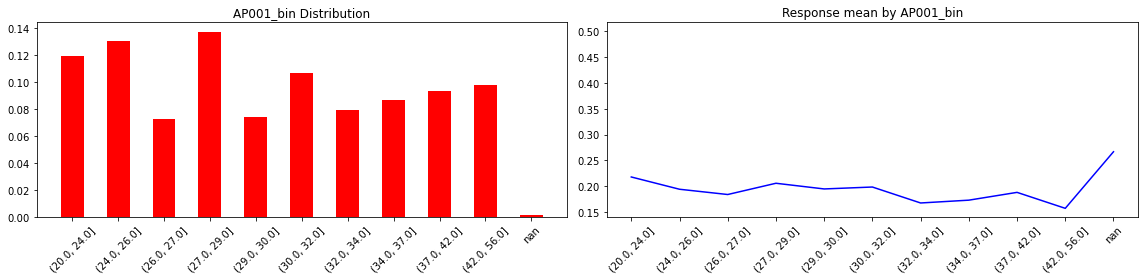

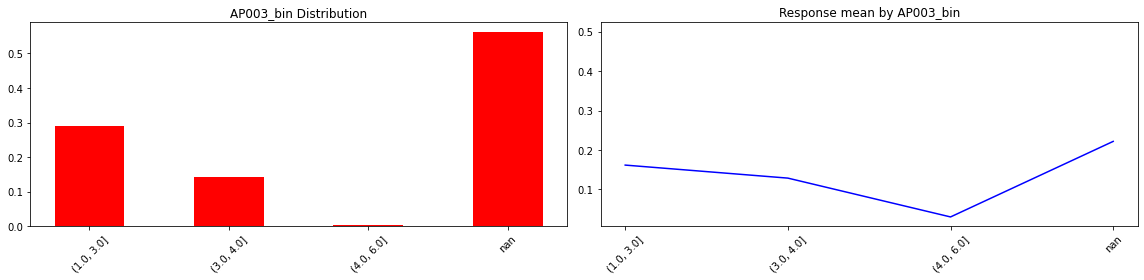

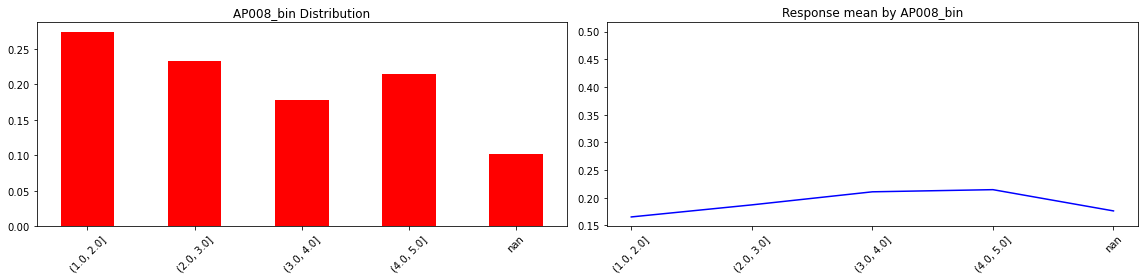

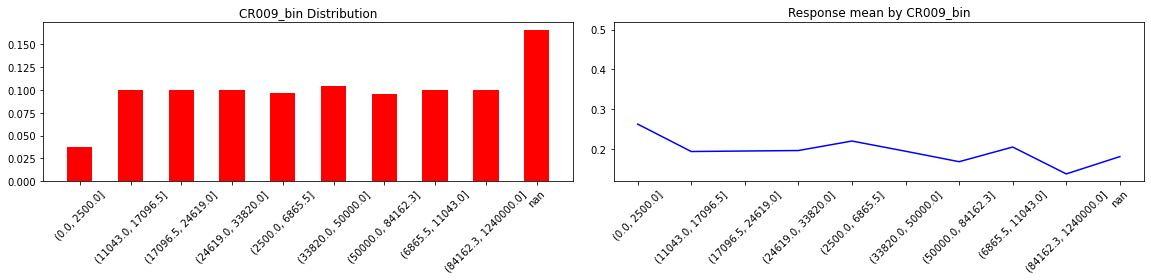

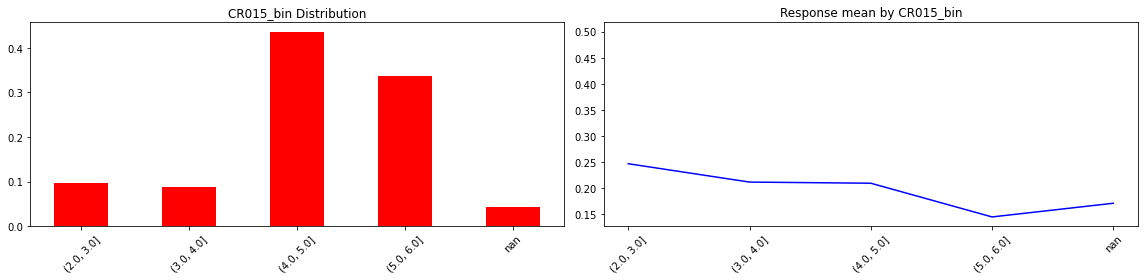

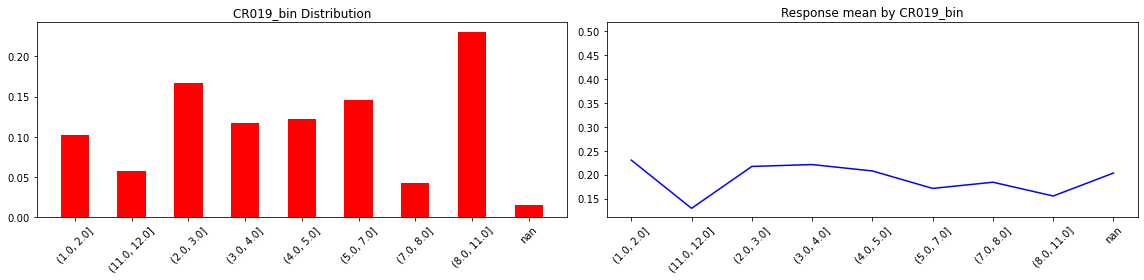

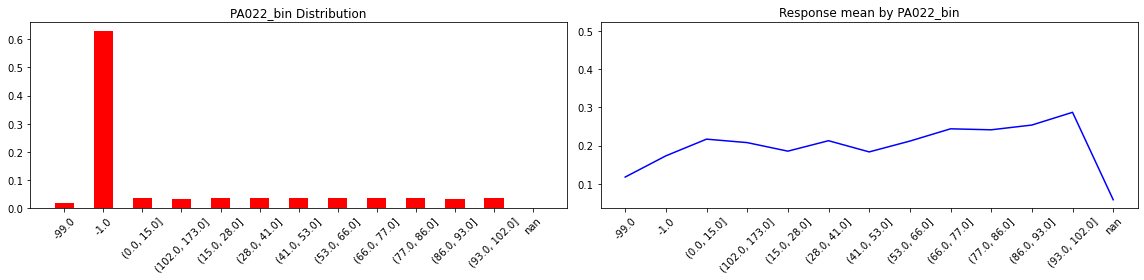

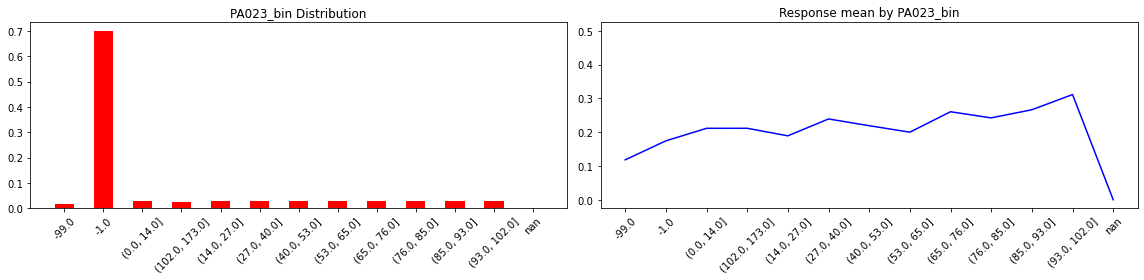

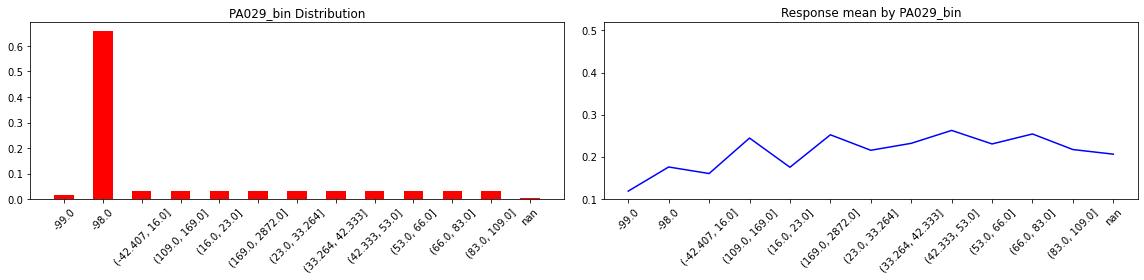

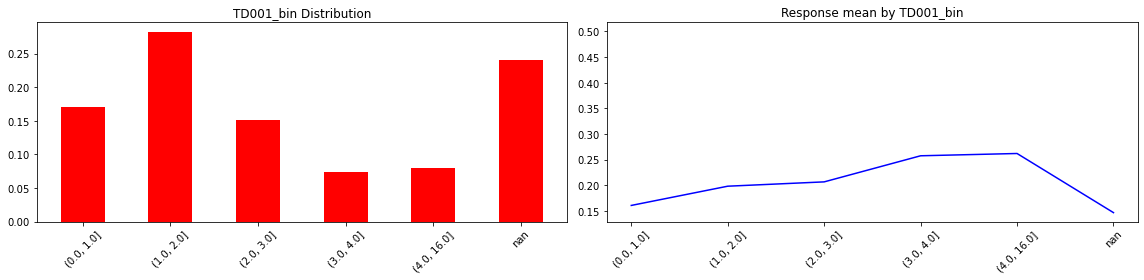

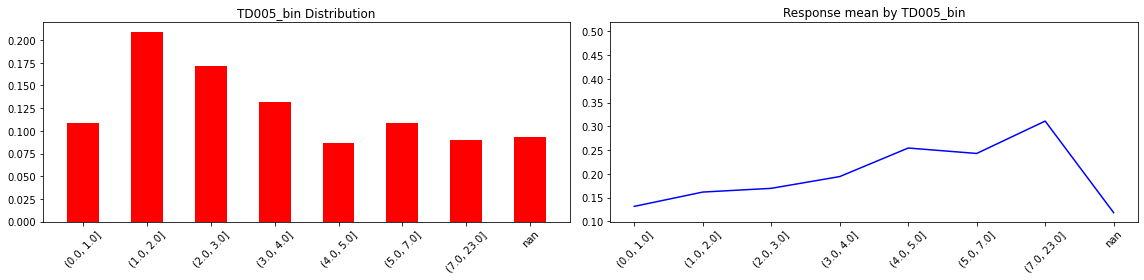

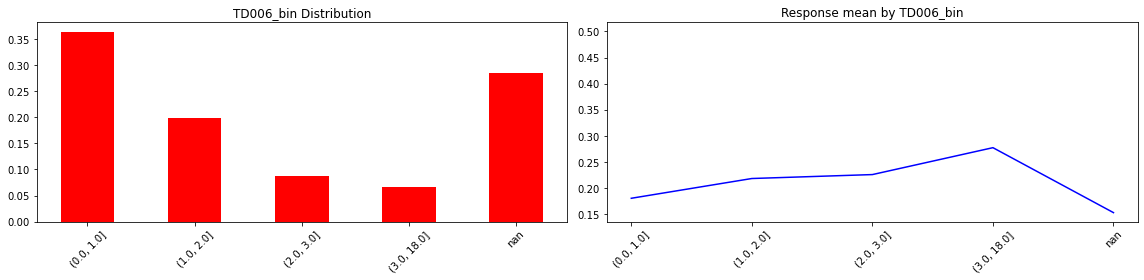

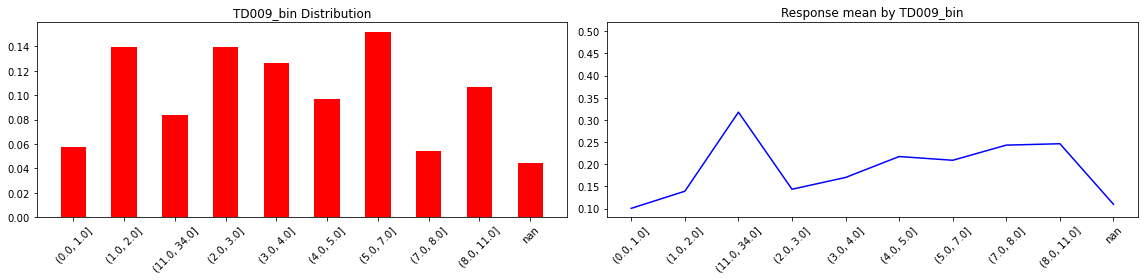

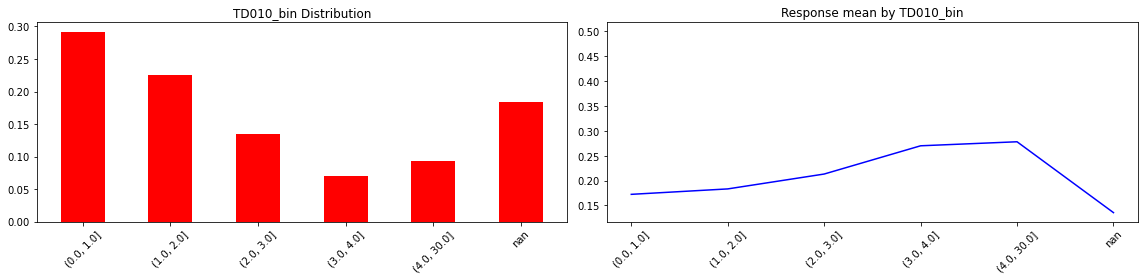

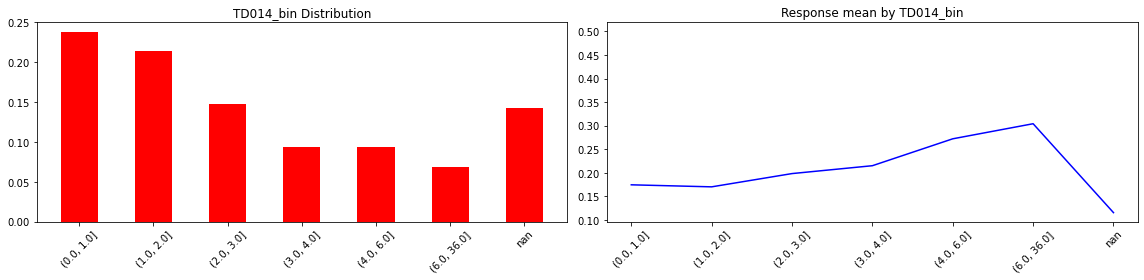

In [24]:
# Show the distribution of the train dataset
def plot_X_and_Y(var):
    z = train.groupby(var)['loan_default'].agg(['count', 'mean']).reset_index() 
    z['count_pcnt'] = z['count']/z['count'].sum()
    x = z[var]
    y_mean = z['mean']
    count_pcnt = z['count_pcnt']
    ind = np.arange(0, len(x))
    width = .5

    fig, axs = plt.subplots(ncols=2, figsize=(16,4))
    axs[0].bar(ind, count_pcnt, width, color='r')
    axs[0].set_title(var + ' Distribution')
    axs[0].set_xticks(ind)
    axs[0].set_xticklabels(x.tolist(), rotation=45)
    
    axs[1].plot(ind, y_mean, width, color='b')
    axs[1].set_title('Response mean by ' + var)
    axs[1].set_xticks(ind)
    axs[1].set_xticklabels(x.tolist(), rotation=45)
    
    plt.tight_layout()
    plt.show()
    
for i in features_bin:
    plot_X_and_Y(i) 

### WOE transformation

In [25]:
# Create WOE function
def WOE(var, train):
    train[var] = train[var].fillna('NoData')
    k = train[[var,'loan_default']].groupby(var)['loan_default'].agg(['count','sum']).reset_index()
    k.columns = [var,'Count','Good']
    k['Bad'] = k['Count'] - k['Good']
    k['Good %'] = (k['Good'] / k['Good'].sum()*100).round(2)
    k['Bad %'] = (k['Bad'] / k['Bad'].sum()*100).round(2)
    k[var+'_WOE'] = np.log(k['Good %'] / k['Bad %']).round(2)
    k = k.sort_values(by=var+'_WOE')
    
    return(k)

In [26]:
for f in features_bin:
    try:
        k = WOE(f, train)
        train[f+'_WOE'] = train[f].map(k.set_index(f)[f+'_WOE'])
        train[f+'_WOE'] = train[f+'_WOE'].fillna(k[f+'_WOE'].iloc[-1])
        test[f+'_WOE'] = test[f].map(k.set_index(f)[f+'_WOE'])
        test[f+'_WOE'] = test[f+'_WOE'].fillna(k[f+'_WOE'].iloc[-1])
        #Merge WOE variable from training dataset to test dataset
        test[f+'_WOE'] = test[f+'_WOE'].fillna(train[f+'_WOE'].iloc[-1])
    except:
        pass

# Section 3: H2O

H2O has proven to be one of the favorite tools of many data scientists. It streamlines modeling development and production and can produce models that can be run in other languages such as Java.

In [255]:
#pip install h2o

In [460]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_361"; Java(TM) SE Runtime Environment (build 1.8.0_361-b09); Java HotSpot(TM) 64-Bit Server VM (build 25.361-b09, mixed mode)
  Starting server from /Users/kanyaratsuwannama/opt/anaconda3/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/4q/w1lktl152hx0j0gq933rclnh0000gn/T/tmp4ow6d5zw
  JVM stdout: /var/folders/4q/w1lktl152hx0j0gq933rclnh0000gn/T/tmp4ow6d5zw/h2o_kanyaratsuwannama_started_from_python.out
  JVM stderr: /var/folders/4q/w1lktl152hx0j0gq933rclnh0000gn/T/tmp4ow6d5zw/h2o_kanyaratsuwannama_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.2
H2O_cluster_version_age:,19 days
H2O_cluster_name:,H2O_from_python_kanyaratsuwannama_md4ap0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.770 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [461]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

In [462]:
predictors = ['AP001_bin_WOE', 'AP003_bin_WOE', 'AP008_bin_WOE', 'CR009_bin_WOE', 'CR015_bin_WOE', 'CR019_bin_WOE', 'PA022_bin_WOE', 'PA023_bin_WOE', 'PA029_bin_WOE', 'TD001_bin_WOE', 'TD005_bin_WOE', 'TD006_bin_WOE', 'TD009_bin_WOE', 'TD010_bin_WOE', 'TD014_bin_WOE']
target = 'loan_default'

In [463]:
train_smpl = train.sample(frac=0.1, random_state=1)
test_smpl = test.sample(frac=0.1, random_state=1)
train_hex = h2o.H2OFrame(train_smpl)
test_hex = h2o.H2OFrame(test_smpl)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [459]:
#h2o.cluster().shutdown()

H2O session _sid_ac8b closed.


# Section 4: GBM models

GBM (Gradient Boosting Machine) is a machine learning algorithm that is used for both regression and classification problems. It is a type of ensemble method that combines multiple weak models (typically decision trees) into a single strong model. It works by fitting individual trees sequentially to the residuals of the previous tree and can handle a wide range of data types. GBM is a powerful algorithm but can be computationally expensive and prone to overfitting.

### Model 1

In [104]:
# Model 1 
from h2o.estimators import H2OGradientBoostingEstimator
gbm_vl = H2OGradientBoostingEstimator(
        model_id = 'gbm_vl',
        ntrees = 300,
        nfolds=10,
        min_rows=100,
        seed=1234)
gbm_vl.train(predictors,target,training_frame=train_hex)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: gbm_vl


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    300                300                         40493                  3            5            4.11667       5             7             6.01

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.10557797333411977
RMSE: 0.32492764322864215
MAE: 0.24958891390968346
RMSLE: 0.2266425605565507
Mean Residual Deviance: 0.10557797333411977

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 0.1760611081697268
RMSE: 0.4195963633895399
MAE: 0.3241773349675443
RMSLE: 0.29899743802346007
Mean Residual Deviance: 0.1760611081697268

Cross-Validation Metrics Summary: 
                        mean       sd         cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
----------------------  ---------  ---------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
mae                     0.32462    0.0371967  0.347051      0.274065      0.332828      0.353991      0.309575      0.358988      0.290244      0.370439      0.266         0.343019
mean_residual_deviance  0.17662    0.0350838  0.207997      0.129009      0.171958      0.216864      0.151541      0.212341      0.151568      0.21356       0.129117      0.182242
mse                     0.17662    0.0350838  0.207997      0.129009      0.171958      0.216864      0.151541      0.212341      0.151568      0.21356       0.129117      0.182242
r2                      -0.107246  0.136247   -0.0401673    0.0131358     0.0258052     -0.0709443    -0.451579     -0.177836     -0.120437     -0.0383166    -0.123093     -0.0890254
residual_deviance       0.17662    0.0350838  0.207997      0.129009      0.171958      0.216864      0.151541      0.212341      0.151568      0.21356       0.129117      0.182242
rmse                    0.418337   0.0423493  0.456067      0.359178      0.414679      0.465687      0.389283      0.460804      0.389317      0.462125      0.359329      0.426898
rmsle                   0.298571   0.0239668  0.314304      0.260978      0.294098      0.319788      0.29404       0.327409      0.282744      0.321747      0.262425      0.30818

Scoring History: 
     timestamp            duration    number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  ----------  -----------------  -------------------  -------------------  -------------------
     2023-03-28 14:07:00  5.983 sec   0.0                0.4064153509649923   0.33034687500000187  0.16517343749999788
     2023-03-28 14:07:00  5.993 sec   1.0                0.4048534904301166   0.32901309633627535  0.1639063487134485
     2023-03-28 14:07:00  6.001 sec   2.0                0.40281768667745127  0.32720593966543676  0.1622620887001733
     2023-03-28 14:07:00  6.009 sec   3.0                0.40118251786084774  0.32568546492606404  0.16094741263716944
     2023-03-28 14:07:00  6.016 sec   4.0                0.3995611425692275   0.3241390697658062   0.15964910665122653
     2023-03-28 14:07:00  6.020 sec   5.0                0.39807822753864     0.3226091981679201   0.1584662752403052
     2023-03-28 14:07:00  6.023 sec   6.0                0.39646315419063577  0.32097211929038166  0.15718303263078784
     2023-03-28 14:07:00  6.025 sec   7.0                0.39532262766553344  0.31969124257564546  0.15627997994438197
     2023-03-28 14:07:00  6.028 sec   8.0                0.39437616897459304  0.3185517416521907   0.15553256265507678
     

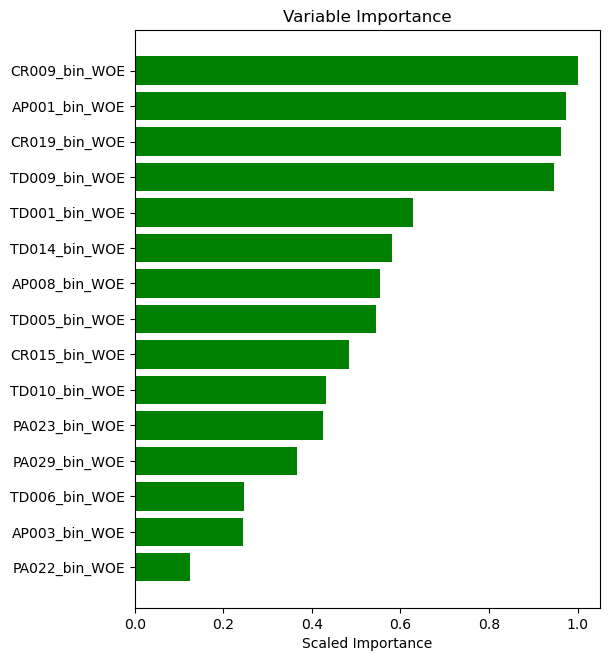

In [105]:
def VarImp(model_name):
    
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt
    
    # plot the variable importance
    plt.rcdefaults()
    variables = model_name._model_json['output']['variable_importances']['variable']
    y_pos = np.arange(len(variables))
    fig, ax = plt.subplots(figsize = (6,len(variables)/2))
    scaled_importance = model_name._model_json['output']['variable_importances']['scaled_importance']
    ax.barh(y_pos,scaled_importance,align='center',color='green')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(variables)
    ax.invert_yaxis()
    ax.set_xlabel('Scaled Importance')
    ax.set_title('Variable Importance')
    plt.show()

VarImp(gbm_vl)

In [106]:
# function to plot the Cumulative lift
def createGains(model):
    predictions = model.predict(test_hex)
    test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()

    #sort on prediction (descending), add id, and decile for groups containing 1/10 of datapoints
    test_scores = test_scores.sort_values(by='predict',ascending=False)
    test_scores['row_id'] = range(0,0+len(test_scores))
    test_scores['decile'] = ( test_scores['row_id'] / (len(test_scores)/10) ).astype(int)
    #see count by decile
    test_scores.loc[test_scores['decile'] == 10]=9
    test_scores['decile'].value_counts()

    #create gains table
    gains = test_scores.groupby('decile')['loan_default'].agg(['count','sum'])
    gains.columns = ['count','actual']
    gains

    #add features to gains table
    gains['non_actual'] = gains['count'] - gains['actual']
    gains['cum_count'] = gains['count'].cumsum()
    gains['cum_actual'] = gains['actual'].cumsum()
    gains['cum_non_actual'] = gains['non_actual'].cumsum()
    gains['percent_cum_actual'] = (gains['cum_actual'] / np.max(gains['cum_actual'])).round(2)
    gains['percent_cum_non_actual'] = (gains['cum_non_actual'] / np.max(gains['cum_non_actual'])).round(2)
    gains['if_random'] = np.max(gains['cum_actual']) /10 
    gains['if_random'] = gains['if_random'].cumsum()
    gains['lift'] = (gains['cum_actual'] / gains['if_random']).round(2)
    gains['K_S'] = np.abs( gains['percent_cum_actual'] -  gains['percent_cum_non_actual'] ) * 100
    gains['gain']=(gains['cum_actual']/gains['cum_count']*100).round(2)
    gains = pd.DataFrame(gains)
    return(gains)

createGains(gbm_vl)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,720,210,510,720,210,510,0.15,0.09,142.7,1.47,6.0,29.17
1,720,178,542,1440,388,1052,0.27,0.18,285.4,1.36,9.0,26.94
2,720,162,558,2160,550,1610,0.39,0.28,428.1,1.28,11.0,25.46
3,720,147,573,2880,697,2183,0.49,0.38,570.8,1.22,11.0,24.20
4,720,145,575,3600,842,2758,0.59,0.48,713.5,1.18,11.0,23.39
5,720,132,588,4320,974,3346,0.68,0.58,856.2,1.14,10.0,22.55
6,720,121,599,5040,1095,3945,0.77,0.68,998.9,1.10,9.0,21.73
7,720,117,603,5760,1212,4548,0.85,0.79,1141.6,1.06,6.0,21.04
8,720,117,603,6480,1329,5151,0.93,0.89,1284.3,1.03,4.0,20.51


gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



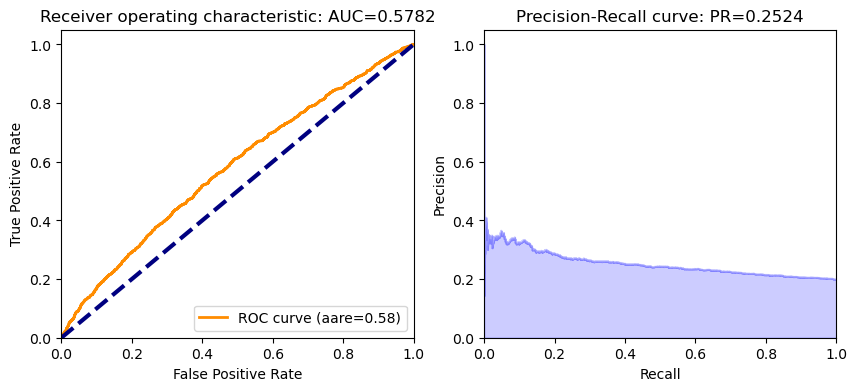

In [107]:
# function to plot the ROC curve
def ROC_AUC(my_result,df,target):
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt

    # ROC
    y_actual = df[target].as_data_frame()
    y_pred = my_result.predict(df).as_data_frame()
    fpr = list()
    tpr = list()
    roc_auc = list()
    fpr,tpr,_ = roc_curve(y_actual,y_pred)
    roc_auc = auc(fpr,tpr)
    
    # Precision-Recall
    average_precision = average_precision_score(y_actual,y_pred)

    print('')
    print('   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate')
    print('')
    print('	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy')
    print('')
    print('   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)')
    print('')
    
    # plotting
    plt.figure(figsize=(10,4))

    # ROC
    plt.subplot(1,2,1)
    plt.plot(fpr,tpr,color='darkorange',lw=2,label='ROC curve (aare=%0.2f)' % roc_auc)
    plt.plot([0,1],[0,1],color='navy',lw=3,linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: AUC={0:0.4f}'.format(roc_auc))
    plt.legend(loc='lower right')

    # Precision-Recall
    plt.subplot(1,2,2)
    precision,recall,_ = precision_recall_curve(y_actual,y_pred)
    plt.step(recall,precision,color='b',alpha=0.2,where='post')
    plt.fill_between(recall,precision,step='post',alpha=0.2,color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0,1.05])
    plt.xlim([0.0,1.0])
    plt.title('Precision-Recall curve: PR={0:0.4f}'.format(average_precision))
    plt.show()
    
ROC_AUC(gbm_vl,test_hex,'loan_default')

### Model 2 - Grid Search

H2OGridSearch is a function in H2O that helps find the best hyperparameters for a machine learning algorithm by exploring a pre-defined hyperparameter grid and training and evaluating a model for each combination of hyperparameters. It can be used with different algorithms in H2O, and it returns the best model and its hyperparameters.

In [373]:
from h2o.grid.grid_search import H2OGridSearch
gbm_params = {
    'ntrees': [300, 400, 500],
    'max_depth': [3, 4, 5],
    'learn_rate': [0.001,  0.005, 0.01],
    'min_rows': [50, 75, 100],
    'sample_rate': [0.03, 0.05, 0.08],
    'col_sample_rate': [0.03, 0.05, 0.08]
}

In [374]:
gbm_grid = H2OGridSearch(model=H2OGradientBoostingEstimator(seed = 1234),
                          
                          hyper_params=gbm_params)

In [375]:
gbm_grid.train(predictors,target,training_frame=train_hex)

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


,col_sample_rate,learn_rate,max_depth,min_rows,ntrees,sample_rate,model_ids,residual_deviance
,0.03,0.01,3.0,75.0,500.0,0.05,Grid_GBM_Key_Frame__upload_b38d7b9ec12339ef448da55440804cdd.hex_model_python_1680058693322_1_model_439,0.1550941
,0.05,0.01,3.0,75.0,500.0,0.05,Grid_GBM_Key_Frame__upload_b38d7b9ec12339ef448da55440804cdd.hex_model_python_1680058693322_1_model_440,0.1550941
,0.08,0.01,3.0,75.0,500.0,0.05,Grid_GBM_Key_Frame__upload_b38d7b9ec12339ef448da55440804cdd.hex_model_python_1680058693322_1_model_441,0.1550941
,0.03,0.01,4.0,75.0,500.0,0.05,Grid_GBM_Key_Frame__upload_b38d7b9ec12339ef448da55440804cdd.hex_model_python_1680058693322_1_model_448,0.1550941
,0.05,0.01,4.0,75.0,500.0,0.05,Grid_GBM_Key_Frame__upload_b38d7b9ec12339ef448da55440804cdd.hex_model_python_1680058693322_1_model_449,0.1550941
,0.08,0.01,4.0,75.0,500.0,0.05,Grid_GBM_Key_Frame__upload_b38d7b9ec12339ef448da55440804cdd.hex_model_python_1680058693322_1_model_450,0.1550941
,0.03,0.01,5.0,75.0,500.0,0.05,Grid_GBM_Key_Frame__upload_b38d7b9ec12339ef448da55440804cdd.hex_model_python_1680058693322_1_model_457,0.1550941
,0.05,0.01,5.0,75.0,500.0,0.05,Grid_GBM_Key_Frame__upload_b38d7b9ec12339ef448da55440804cdd.hex_model_python_1680058693322_1_model_458,0.1550941
,0.08,0.01,5.0,75.0,500.0,0.05,Grid_GBM_Key_Frame__upload_b38d7b9ec12339ef448da55440804cdd.hex_model_python_1680058693322_1_model_459,0.1550941
,0.03,0.01,3.0,100.0,500.0,0.03,Grid_GBM_Key_Frame__upload_b38d7b9ec12339ef448da55440804cdd.hex_model_python_1680058693322_1_model_223,0.1551576


In [376]:
gbm_v2 = H2OGradientBoostingEstimator(
        model_id = 'gmb_v2',
        ntrees = 500,
        min_rows = 75,
        max_depth = 3,
        learn_rate=0.01,
        col_sample_rate = 0.03,
        sample_rate = 0.05,
        nfolds=10,
        seed=1234)
gbm_v2.train(predictors,target,training_frame=train_hex)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: gmb_v2


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    500                500                         42355                  1            1            1             2             2             2

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.15509412389485214
RMSE: 0.3938199130247887
MAE: 0.3130723111052066
RMSLE: 0.27480790895975166
Mean Residual Deviance: 0.15509412389485214

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 0.16060110227611316
RMSE: 0.40075067345684295
MAE: 0.3186010243498385
RMSLE: 0.2803609245117291
Mean Residual Deviance: 0.16060110227611316

Cross-Validation Metrics Summary: 
                        mean         sd         cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
----------------------  -----------  ---------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
mae                     0.318846     0.0315077  0.353381      0.290085      0.322979      0.3489        0.278712      0.338356      0.295017      0.358592      0.27638       0.32606
mean_residual_deviance  0.160894     0.0340887  0.199974      0.127856      0.164417      0.196947      0.114525      0.183415      0.136384      0.202228      0.121398      0.161792
mse                     0.160894     0.0340887  0.199974      0.127856      0.164417      0.196947      0.114525      0.183415      0.136384      0.202228      0.121398      0.161792
r2                      -0.00107277  0.0473872  -4.55886e-05  0.021955      0.0685294     0.0274139     -0.0970056    -0.0173861    -0.00819035   0.016777      -0.0559483    0.0331729
residual_deviance       0.160894     0.0340887  0.199974      0.127856      0.164417      0.196947      0.114525      0.183415      0.136384      0.202228      0.121398      0.161792
rmse                    0.399037     0.0429913  0.447185      0.357569      0.405484      0.443787      0.338415      0.428269      0.369302      0.449698      0.348422      0.402234
rmsle                   0.279798     0.0215338  0.304696      0.258044      0.280095      0.300623      0.251428      0.297282      0.264688      0.304854      0.253858      0.282416

Scoring History: 
     timestamp            duration    number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  ----------  -----------------  -------------------  -------------------  -------------------
     2023-03-28 23:15:36  9.642 sec   0.0                0.4064153509649923   0.33034687500000187  0.16517343749999788
     2023-03-28 23:15:36  9.645 sec   1.0                0.4064391359942268   0.33031899988651275  0.1651927712677336
     2023-03-28 23:15:36  9.646 sec   2.0                0.4064177979799707   0.3307262080721557   0.16517542651488828
     2023-03-28 23:15:36  9.648 sec   3.0                0.4062766196877879   0.33065231101587417  0.16506069170493545
     2023-03-28 23:15:36  9.649 sec   4.0                0.4062042221957019   0.33020608076825736  0.16500187012961517
     2023-03-28 23:15:36  9.651 sec   5.0                0.40618824344425375  0.32928743479773404  0.16498888911232837
     2023-03-28 23:15:36  9.652 sec   6.0                0.406167487236936    0.32876903798431156  0.1649720276883666
     2023-03-28 23:15:36  9.654 sec   7.0                0.40601062312914826  0.3287356577441096   0.16484462609371925
     2023-03-28 23:15:36  9.655 sec   8.0                0.40605900312772947  0.328485622741282    0.1648839

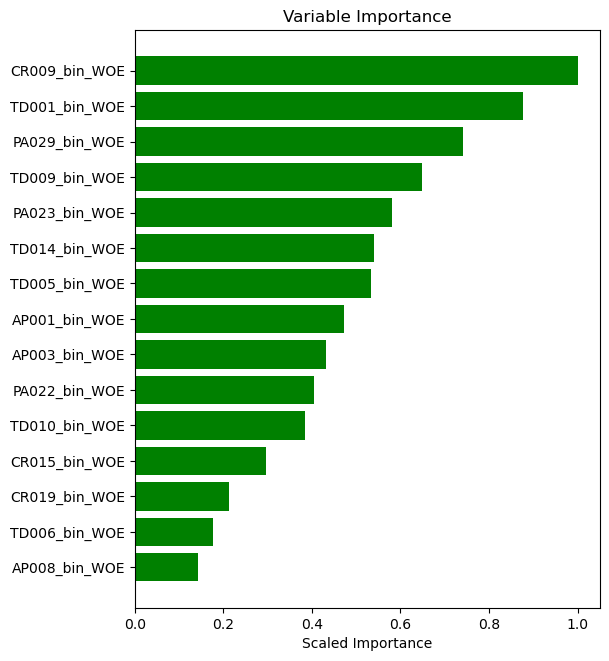

In [377]:
VarImp(gbm_v2)

In [378]:
createGains(gbm_v2)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,720,220,500,720,220,500,0.15,0.09,142.7,1.54,6.0,30.56
1,720,196,524,1440,416,1024,0.29,0.18,285.4,1.46,11.0,28.89
2,720,187,533,2160,603,1557,0.42,0.27,428.1,1.41,15.0,27.92
3,720,183,537,2880,786,2094,0.55,0.36,570.8,1.38,19.0,27.29
4,720,132,588,3600,918,2682,0.64,0.46,713.5,1.29,18.0,25.50
5,720,136,584,4320,1054,3266,0.74,0.57,856.2,1.23,17.0,24.40
6,720,95,625,5040,1149,3891,0.81,0.67,998.9,1.15,14.0,22.80
7,720,99,621,5760,1248,4512,0.87,0.78,1141.6,1.09,9.0,21.67
8,720,97,623,6480,1345,5135,0.94,0.89,1284.3,1.05,5.0,20.76


gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



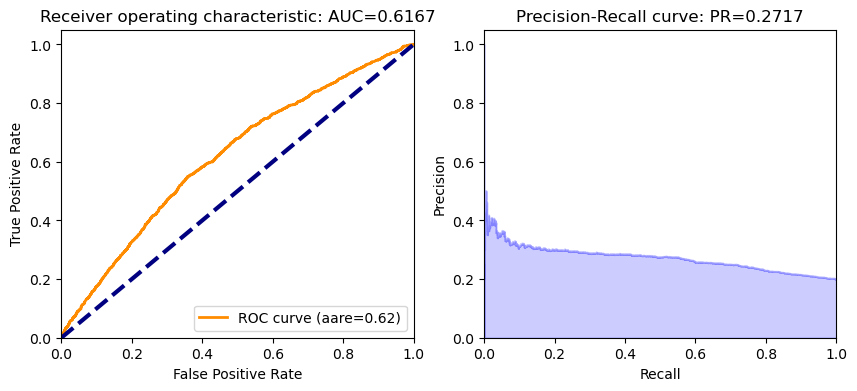

In [379]:
ROC_AUC(gbm_v2,test_hex,'loan_default')

# Section 5: Deep Learning

Deep learning is a type of machine learning that uses neural networks with multiple layers to automatically learn from data and extract high-level features. It is effective for complex tasks such as image and speech recognition and has been successfully applied in various fields such as computer vision and natural language processing.

### Model 1

In [350]:
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
DL_modl = H2ODeepLearningEstimator(
    distribution="tweedie",
    activation="RectifierWithDropout",
    hidden=[32,32,32],
    input_dropout_ratio=0.2,
    sparse=True,
    l1=1e-5,
    epochs=10)

In [351]:
DL_modl.train(
    x=predictors,
    y=target,
    training_frame=train_hex,
    validation_frame=test_hex)

deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_model_python_1680044398875_18


Status of Neuron Layers: predicting loan_default, regression, tweedie distribution, Automatic loss, 2,657 weights/biases, 39.4 KB, 8,000 training samples, mini-batch size 1
    layer    units    type              dropout    l1     l2    mean_rate               rate_rms                momentum    mean_weight            weight_rms           mean_bias             bias_rms
--  -------  -------  ----------------  ---------  -----  ----  ----------------------  ----------------------  ----------  ---------------------  -------------------  --------------------  -----------------------
    1        15       Input             20.0
    2        32       RectifierDropout  50.0       1e-05  0.0   0.001435473223803759    0.00043990020640194416  0.0         -0.005254614379615911  0.20735371112823486  0.49365981424038247   0.05450759828090668
    3        32       RectifierDropout  50.0       1e-05  0.0   0.0015634572900182775   0.0007355592679232359   0.0         -0.008486142777854866  0.1885077953338623   0.9691335537756977    0.12838470935821533
    4        32       RectifierDropout  50.0       1e-05  0.0   0.002600763318071131    0.004083726555109024    0.0         -0.008116994503287955  0.18404895067214966  0.9430244856204527    0.08881807327270508
    5        1        Linear                       1e-05  0.0   0.00021275266203701904  8.756888564676046e-05   0.0         -0.05112422718957532   0.21454620361328125  -0.19127976900551083  1.0971281125650402e-154

ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 0.15807957014181395
RMSE: 0.3975922158969086
MAE: 0.31875644431204525
RMSLE: 0.2780844821113803
Mean Residual Deviance: 1.90712832279296

ModelMetricsRegression: deeplearning
** Reported on validation data. **

MSE: 0.15422140919492838
RMSE: 0.39271033751981677
MAE: 0.314090011364567
RMSLE: 0.27619053322305137
Mean Residual Deviance: 1.924846554051911

Scoring History: 
    timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_deviance    training_mae    training_r2    validation_rmse    validation_deviance    validation_mae    validation_r2
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  -------------------  --------------  -------------  -----------------  ---------------------  ----------------  ---------------
    2023-03-28 19:54:41  0.000 sec                     0         0             0          nan              nan                  nan             nan            nan                nan                    nan               nan
    2023-03-28 19:54:41  0.197 sec   72727 obs/sec     1         1             800        0.407398         1.99505              0.304795        -0.00483956    0.398959           1.97958                0.297791          -0.00160217
    2023-03-28 19:54:42  0.387 sec   101265 obs/sec    10        10            8000       0.397592         1.90713              0.318756        0.042948       0.39271            1.92485                0.31409           0.0295255

Variable Importances: 
variable       relative_importance    scaled_importance    percentage
-------------  ---------------------  -------------------  ------------
TD005_bin_WOE  1                      1                    0.0759481
TD014_bin_WOE  0.976992               0.976992             0.0742007
TD006_bin_WOE  0.943124               0.943124             0.0716285
TD001_bin_WOE  0.936126               0.936126             0.071097
TD010_bin_WOE  0.913971               0.913971             0.0694144
CR009_bin_WOE  0.910598               0.910598             0.0691582
PA029_bin_WOE  0.906839               0.906839             0.0688727
CR019_bin_WOE  0.901804               0.901804             0.0684903
AP008_bin_WOE  0.888151               0.888151             0.0674534
AP001_bin_WOE  0

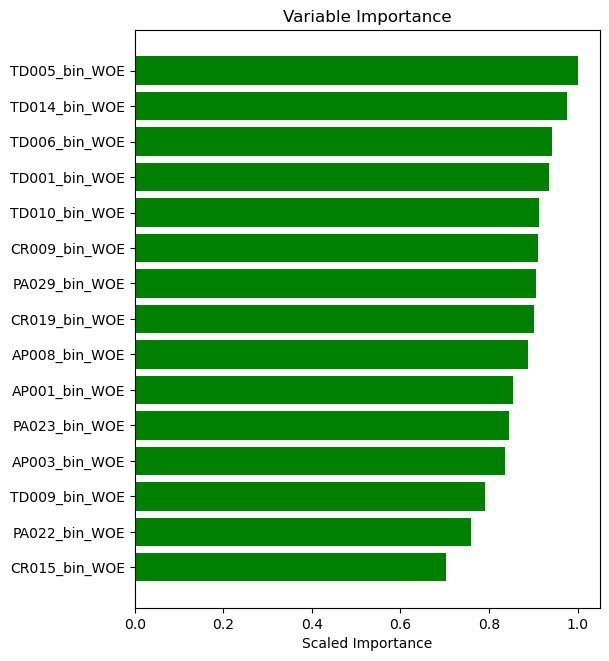

In [352]:
VarImp(DL_modl)

In [115]:
from sklearn.metrics import roc_auc_score
def actual_predict(model,test_hex,target):
    y_pred = model.predict(test_hex).as_data_frame()
    y_actual = test_hex[target].as_data_frame()
    df_actual_predict = pd.concat([y_actual,y_pred],axis=1)
    df_actual_predict.columns = ['actual','pred']
    return(df_actual_predict)

In [116]:
DL_actual_predict = actual_predict(DL_modl,test_hex,target)
DL_roc_auc_value = roc_auc_score(DL_actual_predict['actual'],
                    DL_actual_predict['pred'])
DL_roc_auc_value

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


0.6056398397149041

In [119]:
createGains(DL_modl)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,720,211,509,720,211,509,0.15,0.09,142.7,1.48,6.0,29.31
1,720,189,531,1440,400,1040,0.28,0.18,285.4,1.40,10.0,27.78
2,720,184,536,2160,584,1576,0.41,0.27,428.1,1.36,14.0,27.04
3,720,173,547,2880,757,2123,0.53,0.37,570.8,1.33,16.0,26.28
4,720,145,575,3600,902,2698,0.63,0.47,713.5,1.26,16.0,25.06
5,720,120,600,4320,1022,3298,0.72,0.57,856.2,1.19,15.0,23.66
6,720,131,589,5040,1153,3887,0.81,0.67,998.9,1.15,14.0,22.88
7,720,96,624,5760,1249,4511,0.88,0.78,1141.6,1.09,10.0,21.68
8,720,93,627,6480,1342,5138,0.94,0.89,1284.3,1.04,5.0,20.71


deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



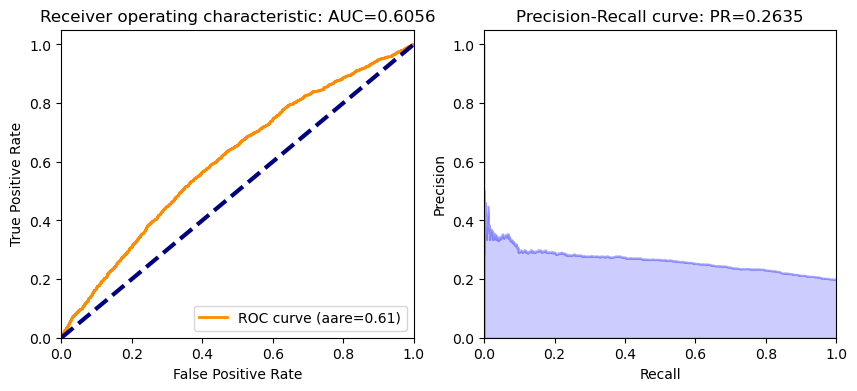

In [118]:
ROC_AUC(DL_modl,test_hex,'loan_default')

### Model 2 - H2OGridSearch

H2OGridSearch is a function in H2O that helps find the best hyperparameters for a machine learning algorithm by exploring a pre-defined hyperparameter grid and training and evaluating a model for each combination of hyperparameters. It can be used with different algorithms in H2O, and it returns the best model and its hyperparameters.

In [464]:
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.grid.grid_search import H2OGridSearch
DL_params = {'activation': ["Rectifier", "RectifierWithDropout", "Tanh", "TanhWithDropout"],
                'hidden': [[50,50], [100,100], [150,150]],
                'input_dropout_ratio': [0.1, 0.2],
                'l1': [1e-4, 1e-5],
                'epochs': [30, 50, 100]}

In [465]:
DL_grid = H2OGridSearch(model=H2ODeepLearningEstimator(seed = 1234),
                          
                          hyper_params=DL_params)
DL_grid

Model,"Hyperparameters: [activation, hidden, input_dropout_ratio, l1, epochs]"
1,"['Rectifier', [50, 50], 0.1, 0.0001, 30]"
2,"['Rectifier', [50, 50], 0.1, 0.0001, 50]"
3,"['Rectifier', [50, 50], 0.1, 0.0001, 100]"
4,"['Rectifier', [50, 50], 0.1, 1e-05, 30]"
5,"['Rectifier', [50, 50], 0.1, 1e-05, 50]"
6,"['Rectifier', [50, 50], 0.1, 1e-05, 100]"
7,"['Rectifier', [50, 50], 0.2, 0.0001, 30]"
8,"['Rectifier', [50, 50], 0.2, 0.0001, 50]"
9,"['Rectifier', [50, 50], 0.2, 0.0001, 100]"
10,"['Rectifier', [50, 50], 0.2, 1e-05, 30]"


In [466]:
DL_grid.train(predictors,target,training_frame=train_hex)

deeplearning Grid Build progress: |██████████████████████████████████████████████| (done) 100%


,activation,epochs,hidden,input_dropout_ratio,l1,model_ids,residual_deviance
,Tanh,100.0,"[100, 100]",0.1,1e-05,Grid_DeepLearning_Key_Frame__upload_982e6a27ef6def721e5f7070643a47c0.hex_model_python_1680095278359_1_model_95,0.0709584
,Rectifier,100.0,"[150, 150]",0.1,1e-05,Grid_DeepLearning_Key_Frame__upload_982e6a27ef6def721e5f7070643a47c0.hex_model_python_1680095278359_1_model_105,0.0710422
,Tanh,100.0,"[150, 150]",0.1,1e-05,Grid_DeepLearning_Key_Frame__upload_982e6a27ef6def721e5f7070643a47c0.hex_model_python_1680095278359_1_model_107,0.0734880
,Rectifier,100.0,"[150, 150]",0.1,0.0001,Grid_DeepLearning_Key_Frame__upload_982e6a27ef6def721e5f7070643a47c0.hex_model_python_1680095278359_1_model_33,0.0820529
,Rectifier,100.0,"[100, 100]",0.1,1e-05,Grid_DeepLearning_Key_Frame__upload_982e6a27ef6def721e5f7070643a47c0.hex_model_python_1680095278359_1_model_93,0.0830765
,Rectifier,100.0,"[50, 50]",0.1,1e-05,Grid_DeepLearning_Key_Frame__upload_982e6a27ef6def721e5f7070643a47c0.hex_model_python_1680095278359_1_model_81,0.0849187
,Tanh,100.0,"[50, 50]",0.1,1e-05,Grid_DeepLearning_Key_Frame__upload_982e6a27ef6def721e5f7070643a47c0.hex_model_python_1680095278359_1_model_83,0.0886833
,Rectifier,100.0,"[150, 150]",0.2,1e-05,Grid_DeepLearning_Key_Frame__upload_982e6a27ef6def721e5f7070643a47c0.hex_model_python_1680095278359_1_model_141,0.0916661
,Tanh,50.0,"[100, 100]",0.1,1e-05,Grid_DeepLearning_Key_Frame__upload_982e6a27ef6def721e5f7070643a47c0.hex_model_python_1680095278359_1_model_91,0.0943196
,Tanh,100.0,"[100, 100]",0.1,0.0001,Grid_DeepLearning_Key_Frame__upload_982e6a27ef6def721e5f7070643a47c0.hex_model_python_1680095278359_1_model_23,0.0953014


In [467]:
DL_mod2 = H2ODeepLearningEstimator(
    distribution="tweedie",
    activation="Tanh",
    hidden=[100, 100],
    input_dropout_ratio=0.1,
    sparse=True,
    l1=1e-5,
    epochs=100)

In [468]:
DL_mod2.train(
    x=predictors,
    y=target,
    training_frame=train_hex,
    validation_frame=test_hex)

deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_model_python_1680095278359_2


Status of Neuron Layers: predicting loan_default, regression, tweedie distribution, Automatic loss, 11,801 weights/biases, 147.1 KB, 80,000 training samples, mini-batch size 1
    layer    units    type    dropout    l1     l2    mean_rate              rate_rms                momentum    mean_weight             weight_rms           mean_bias              bias_rms
--  -------  -------  ------  ---------  -----  ----  ---------------------  ----------------------  ----------  ----------------------  -------------------  ---------------------  -----------------------
    1        15       Input   10.0
    2        100      Tanh    0.0        1e-05  0.0   0.0038085970560011143  0.0019341455772519112   0.0         -0.0030141547359283627  0.1265975832939148   0.007845994913889263   0.06496351957321167
    3        100      Tanh    0.0        1e-05  0.0   0.034548978698486464   0.06777101755142212     0.0         0.0010775565356916559   0.10142257809638977  -0.015529724851476379  0.16044408082962036
    4        1        Linear             1e-05  0.0   0.0005349140669568442  0.00020934734493494034  0.0         -0.003773783206270309   0.1084584891796112   -0.21932056125777505   1.0971281125650402e-154

ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 0.22411979462168183
RMSE: 0.47341292189977435
MAE: 0.32587617923029705
RMSLE: 0.3155012436956119
Mean Residual Deviance: 1.9482228960661785

ModelMetricsRegression: deeplearning
** Reported on validation data. **

MSE: 0.23191416722558605
RMSE: 0.48157467460985326
MAE: 0.3339255753845899
RMSLE: 0.3231755585802732
Mean Residual Deviance: 2.1177150294889233

Scoring History: 
    timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_deviance    training_mae    training_r2    validation_rmse    validation_deviance    validation_mae    validation_r2
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  -------------------  --------------  -------------  -----------------  ---------------------  ----------------  ---------------
    2023-03-29 09:12:41  0.000 sec                     0         0             0          nan              nan                  nan             nan            nan                nan                    nan               nan
    2023-03-29 09:12:41  0.649 sec   19950 obs/sec     10        1             8000       0.473413         1.94822              0.325876        -0.356876      0.481575           2.11772                0.333926          -0.459374
    2023-03-29 09:12:45  4.285 sec   20822 obs/sec     100       10            80000      0.320034         1.05372              0.189801        0.379915       0.508528           2.86673                0.310541          -0.627308
    2023-03-29 09:12:45  4.481 sec   20817 obs/sec     100       10            80000      0.473413         1.94822              0.325876        -0.356876      0.481575           2.11772                0.333926          -0.459374

Variable Importances: 
variable       relative_importance    scaled_importance    percentage
-------------  ---------------------  -------------------  ------------
TD014_bin_WOE  1                      1                    0.0772621
AP003_bin_WOE  0.944197               0.944197             0.0729506
PA022_bin_WOE  0.940608               0.940608             0.0726733
AP001_bin_WOE  0.891187               0.891187             0.068855
CR015_bin_WOE  0.890247               0.890247             0.0687823
TD009_bin_WOE  0.87415                0.87415              0.0675386
AP008_bin_WOE  0.874094               0.874094             0.0675343
PA023_bin_WOE  0.869434               0.869434             0.0671743
PA029_bin_WOE  0.849117               0.849117             0.0656045
TD001_bin_WOE  0.835278               0.835278  

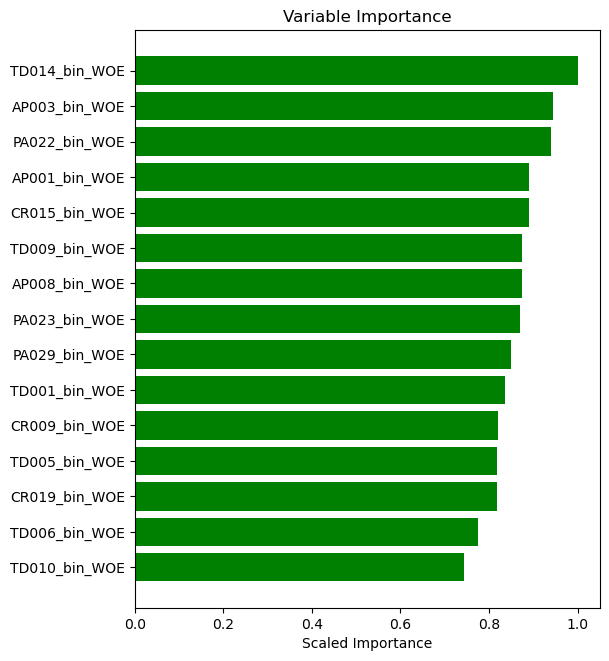

In [470]:
VarImp(DL_mod2)

In [457]:
from sklearn.metrics import roc_auc_score
def actual_predict(model,test_hex,target):
    y_pred = model.predict(test_hex).as_data_frame()
    y_actual = test_hex[target].as_data_frame()
    df_actual_predict = pd.concat([y_actual,y_pred],axis=1)
    df_actual_predict.columns = ['actual','pred']
    return(df_actual_predict)

In [469]:
DL_actual_predict = actual_predict(DL_mod2,test_hex,target)
DL_roc_auc_value = roc_auc_score(DL_actual_predict['actual'],
                    DL_actual_predict['pred'])
DL_roc_auc_value

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


0.6221393333463623

In [471]:
createGains(DL_mod2)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,720,234,486,720,234,486,0.16,0.08,142.7,1.64,8.0,32.50
1,720,201,519,1440,435,1005,0.30,0.17,285.4,1.52,13.0,30.21
2,720,173,547,2160,608,1552,0.43,0.27,428.1,1.42,16.0,28.15
3,720,155,565,2880,763,2117,0.53,0.37,570.8,1.34,16.0,26.49
4,720,138,582,3600,901,2699,0.63,0.47,713.5,1.26,16.0,25.03
5,720,135,585,4320,1036,3284,0.73,0.57,856.2,1.21,16.0,23.98
6,720,134,586,5040,1170,3870,0.82,0.67,998.9,1.17,15.0,23.21
7,720,111,609,5760,1281,4479,0.90,0.78,1141.6,1.12,12.0,22.24
8,720,86,634,6480,1367,5113,0.96,0.89,1284.3,1.06,7.0,21.10


deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



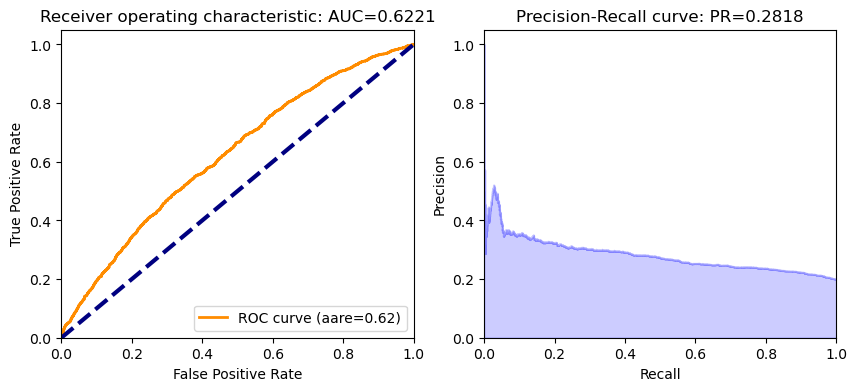

In [472]:
ROC_AUC(DL_mod2,test_hex,'loan_default')

# Section 6: Conclusion 

The objective of this data analysis is to create supervised machine learning models capable of identifying high-risk loans or potential defaults, using 15 features with "loan_default" as the target variable. Feature engineering techniques, such as binning and WOE transformation, were employed to enhance model accuracy and performance. Two supervised ML models, a GBM model and a deep learning model, were developed using simple hyperparameter and hyperparameter tuning from H2O GridSearch, respectively.

### ROC  
The AUC score is a measure of a model's ability to distinguish between positive and negative cases, with a higher score indicating better performance. 

GBM model 
* Model 1 : AUC = 0.5782, PR = 0.2524
* Model 2 : AUC = 0.6167, PR = 0.2717

Deep Learning model
* Model 1 : AUC = 0.6056, PR = 0.2635
* Model 2 : AUC = 0.6221, PR = 0.2818

### Cumulative Lift 
The cumulative lift is a metric that compares the model's results with and without the model to assess its performance. The lift score shows how many times better the model performs compared to the baseline model. 

In summary, based on the ROC and Cumulative lift, the deep learning model with hyper-parameters tuning from H20GridSearch performed the best in identifying high-risk loans or potential defaults, with the AUC = 0.6221, PR = 0.2818 as well as the lift scores. 